In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
import os
import time

%matplotlib inline

In [2]:
# import the raw data
raw = pd.read_csv('../RawData/AAPL_2015_2019.csv')

In [3]:
# check the info
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1256 non-null   object 
 1   Open       1256 non-null   float64
 2   High       1256 non-null   float64
 3   Low        1256 non-null   float64
 4   Close      1256 non-null   float64
 5   Adj Close  1256 non-null   float64
 6   Volume     1256 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.8+ KB


In [4]:
# check the first 5 rows
raw.head()

Date       Open       High        Low      Close  Adj Close  \
0  2015-01-05  27.072500  27.162500  26.352501  26.562500  24.161013   
1  2015-01-06  26.635000  26.857500  26.157499  26.565001  24.163294   
2  2015-01-07  26.799999  27.049999  26.674999  26.937500  24.502111   
3  2015-01-08  27.307501  28.037500  27.174999  27.972500  25.443539   
4  2015-01-09  28.167500  28.312500  27.552500  28.002501  25.470825   

      Volume  
0  257142000  
1  263188400  
2  160423600  
3  237458000  
4  214798000

In [5]:
# check the last 5 rows
raw.tail()

Date       Open       High        Low      Close  Adj Close  \
1251  2019-12-23  70.132500  71.062500  70.092499  71.000000  70.287064   
1252  2019-12-24  71.172501  71.222504  70.730003  71.067497  70.353882   
1253  2019-12-26  71.205002  72.495003  71.175003  72.477501  71.749733   
1254  2019-12-27  72.779999  73.492500  72.029999  72.449997  71.722488   
1255  2019-12-30  72.364998  73.172501  71.305000  72.879997  72.148178   

         Volume  
1251   98572000  
1252   48478800  
1253   93121200  
1254  146266000  
1255  144114400

In [6]:
# read the data again and change it to datatime dataframe
dt_raw = pd.read_csv('..\RawData\AAPL_2015_2019.csv',parse_dates=['Date'],index_col='Date')

In [7]:
# check the info
dt_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2015-01-05 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1256 non-null   float64
 1   High       1256 non-null   float64
 2   Low        1256 non-null   float64
 3   Close      1256 non-null   float64
 4   Adj Close  1256 non-null   float64
 5   Volume     1256 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.7 KB


In [8]:
# check the first 5 rows
dt_raw.head(5)

Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-05  27.072500  27.162500  26.352501  26.562500  24.161013  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  24.163294  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.502111  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  25.443539  237458000
2015-01-09  28.167500  28.312500  27.552500  28.002501  25.470825  214798000

In [9]:
# check the last 5 rows
dt_raw.tail()

Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2019-12-23  70.132500  71.062500  70.092499  71.000000  70.287064   98572000
2019-12-24  71.172501  71.222504  70.730003  71.067497  70.353882   48478800
2019-12-26  71.205002  72.495003  71.175003  72.477501  71.749733   93121200
2019-12-27  72.779999  73.492500  72.029999  72.449997  71.722488  146266000
2019-12-30  72.364998  73.172501  71.305000  72.879997  72.148178  144114400

In [10]:
# group the data from daily to weekly, first day's price as Open, highest price during the week as High,
#   lowest price during the week as Low, last day's price as Close and Adj Close, sum during the week as Volume. 
from pandas.tseries.frequencies import to_offset
loffset= '-6D'
dt_weekly = dt_raw.resample('W').apply(
                            {'Open': 'first', 'High': 'max', 'Low': 'min','Close': 'last', 'Adj Close': 'last', 'Volume': 'sum'}
                            )
dt_weekly.index = dt_weekly.index + to_offset(loffset)

In [11]:
# check the weekly data
dt_weekly

Open       High        Low      Close  Adj Close      Volume
Date                                                                         
2015-01-05  27.072500  28.312500  26.157499  28.002501  25.470825  1133010000
2015-01-12  28.150000  28.200001  26.299999  26.497499  24.101887  1216906400
2015-01-19  26.959999  28.437500  26.625000  28.245001  25.691397   794948000
2015-01-26  28.434999  30.000000  27.257500  29.290001  26.641926  1863370800
2015-02-02  29.512501  30.127501  29.020000  29.732500  27.151154  1083029200
...               ...        ...        ...        ...        ...         ...
2019-12-02  66.817497  67.750000  64.072502  67.677498  66.997925   456599200
2019-12-09  67.500000  68.824997  66.227501  68.787498  68.096771   568117600
2019-12-16  69.250000  70.662498  69.245003  69.860001  69.158508   732720000
2019-12-23  70.132500  73.492500  70.092499  72.449997  71.722488   386438000
2019-12-30  72.364998  73.172501  71.305000  72.879997  72.148178   144114400

[261 rows x 6 columns]

<AxesSubplot:xlabel='Date'>

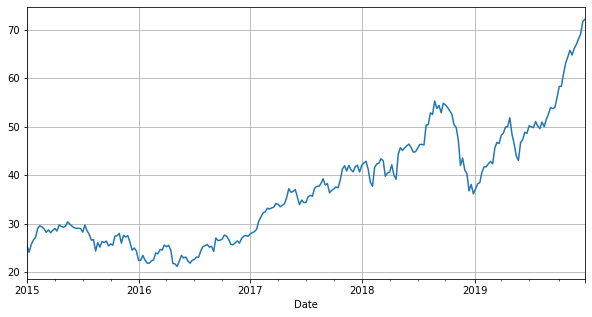

In [12]:
# plot the data to check the basic trend of Adj Close price for 5 years
dt_weekly['Adj Close'].plot(figsize =(10,5), grid=True)

<AxesSubplot:xlabel='Date'>

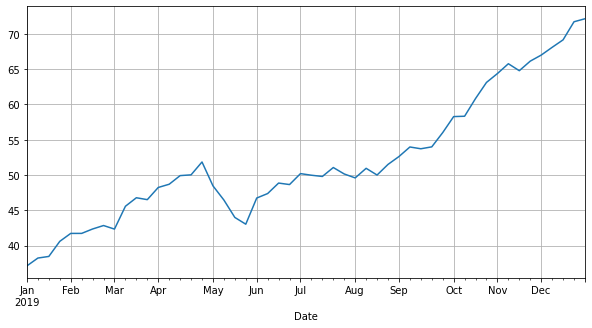

In [13]:
# plot the data to check the basic trend of Adj Close price for one year (2019)
dt_weekly['2019']['Adj Close'].plot(figsize =(10,5), grid=True)

<AxesSubplot:xlabel='Date'>

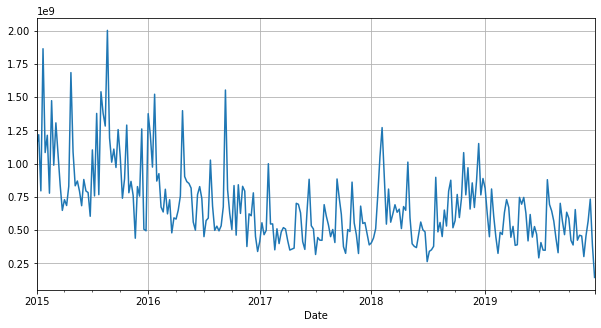

In [14]:
# plot the data to check the trend for trading volume for 5 years
dt_weekly['Volume'].plot(figsize =(10,5), grid=True)

<AxesSubplot:xlabel='Date'>

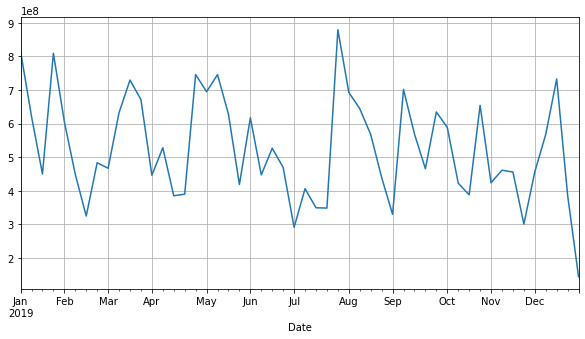

In [15]:
# plot the data to check the trend for trading volume for one year 2019
dt_weekly['2019']['Volume'].plot(figsize =(10,5), grid=True)

<AxesSubplot:>

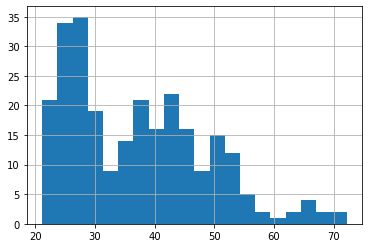

In [16]:
# hist for Adj Close price for 5 years
dt_weekly['Adj Close'].hist(bins=20)

<AxesSubplot:>

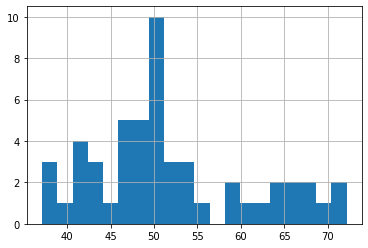

In [17]:
# hist for Adj Close price for one year 2019
dt_weekly['2019']['Adj Close'].hist(bins=20)

<AxesSubplot:xlabel='Date'>

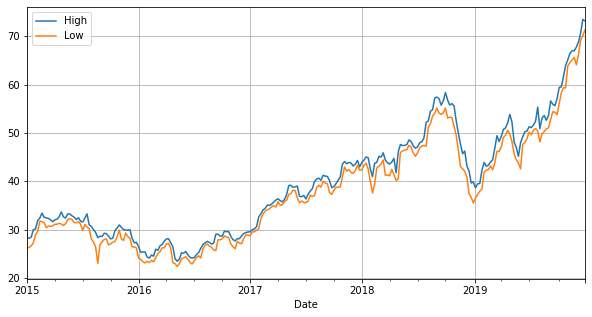

In [18]:
# plot for high and low price for 5 years
dt_weekly[['High','Low']].plot(figsize =(10,5), grid=True)

<AxesSubplot:xlabel='Date'>

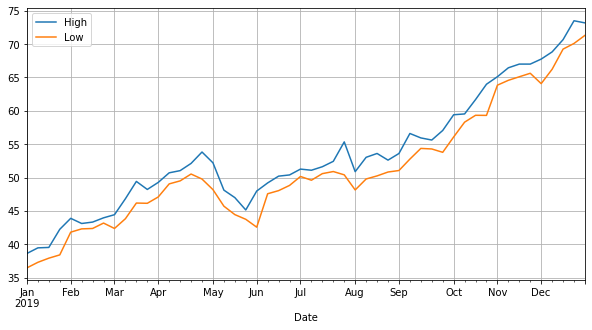

In [19]:
# plot for high and low price for one year 2019
dt_weekly['2019'][['High','Low']].plot(figsize =(10,5), grid=True)

<AxesSubplot:ylabel='Density'>

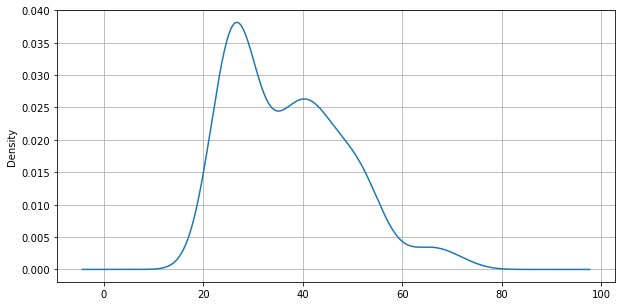

In [20]:
# Kernal Density plot for Adj Close price for 5 years
dt_weekly['Adj Close'].plot(kind='kde',figsize =(10,5), grid=True)

<AxesSubplot:ylabel='Density'>

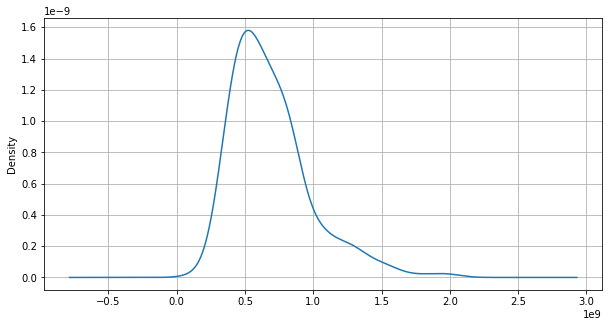

In [21]:
# Kernal Density plot for Volume for 5 years
dt_weekly['Volume'].plot(kind='kde',figsize =(10,5), grid=True)

<AxesSubplot:xlabel='Date'>

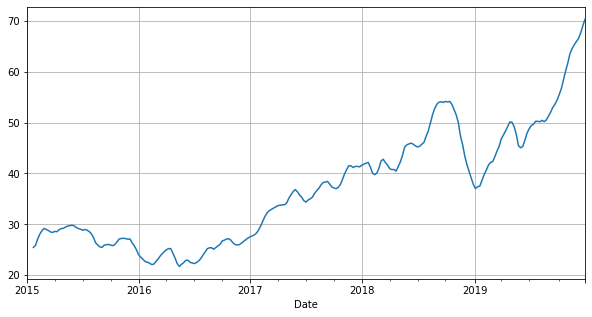

In [22]:
# plot moving average (rolling mean) for Adj Close price
dt_weekly['Adj Close'].rolling(4).mean().plot(figsize =(10,5), grid=True)

<AxesSubplot:xlabel='Date'>

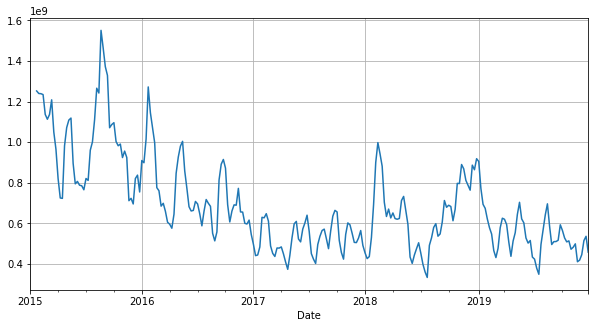

In [23]:
# plot moving average (rolling mean) for Volume
dt_weekly['Volume'].rolling(4).mean().plot(figsize =(10,5), grid=True)

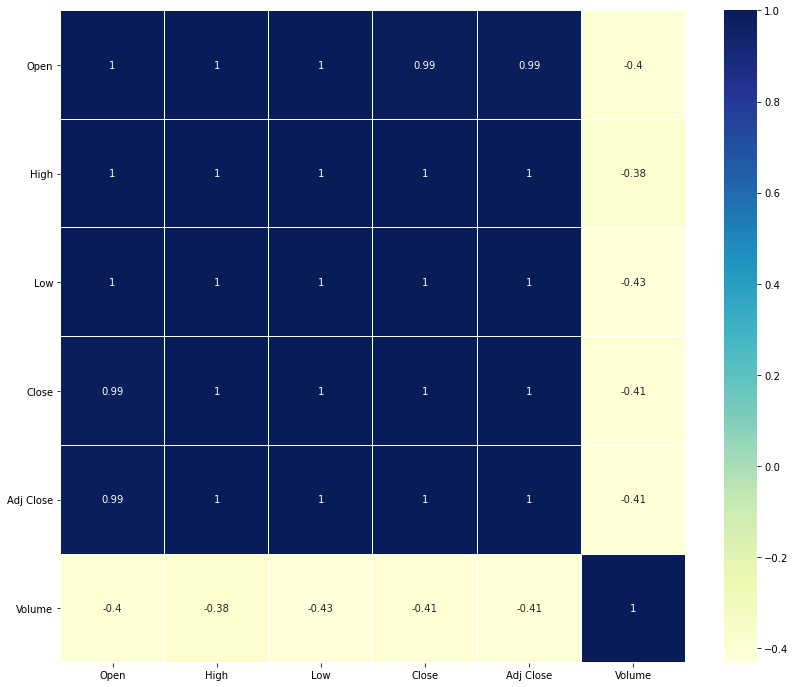

In [24]:
#create the correlation matrix heat map
plt.figure(figsize=(14,12))
sns.heatmap(dt_weekly.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

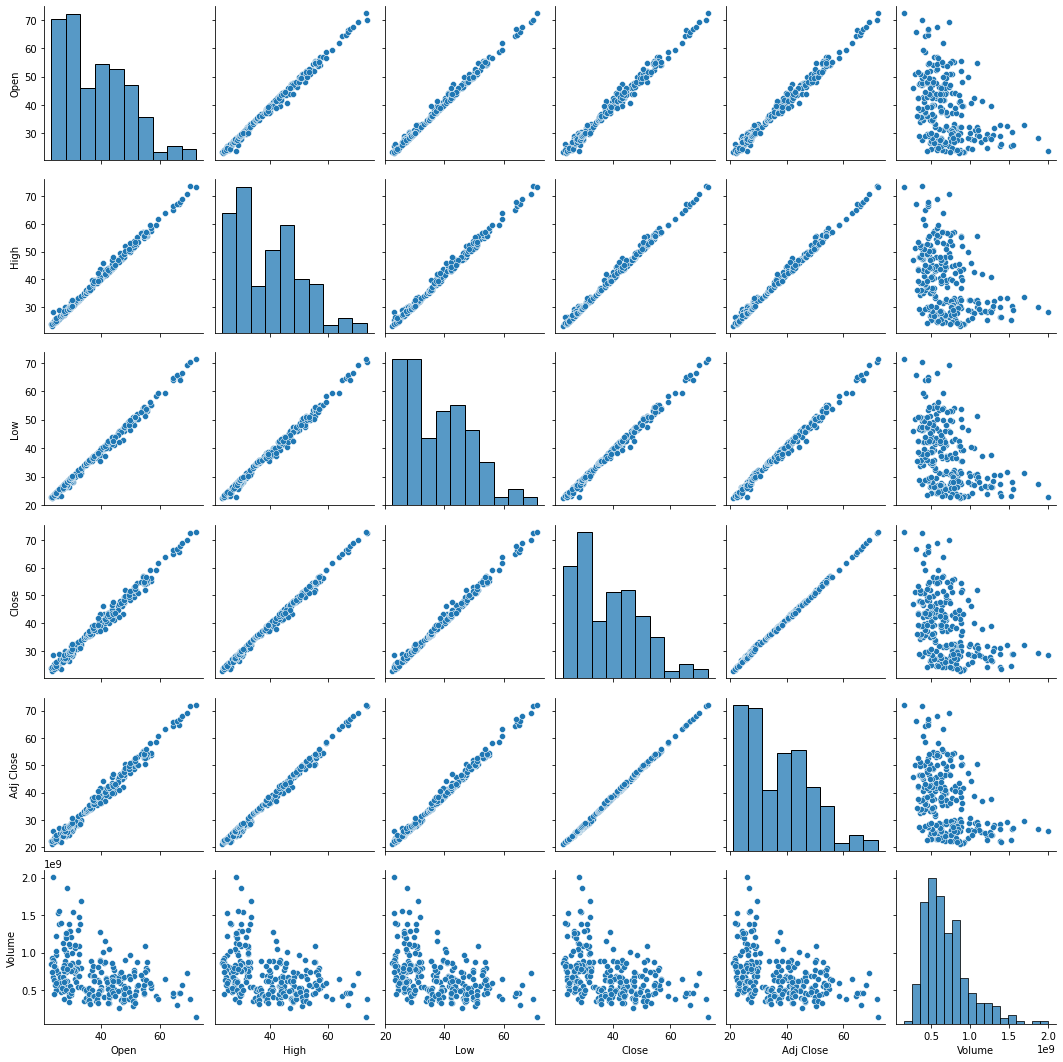

In [25]:
#create the pair plots
sns.pairplot(dt_weekly)

In [26]:
# save the data to new csv file for next step
dt_weekly.to_csv('dt_weekly_eda.csv')